<a href="https://colab.research.google.com/github/GoldHood/IA_NN_Projects_Colab/blob/main/07_Yolo7_PlacasPeru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ✅ Instalar PyTorch con CUDA 11.8 (estable en SageMaker)
!pip install torch==2.2.2+cu118 torchvision==0.17.2+cu118 torchaudio==2.2.2 --extra-index-url https://download.pytorch.org/whl/cu118 -q

# ✅ Instalar librerías adicionales
!pip install opencv-python-headless==4.10.0.84 -q
!pip install cython numpy Pillow matplotlib seaborn pandas tqdm pyyaml scipy thop==0.1.1.post2209072238 -q


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.2 requires nvidia-ml-py3==7.352.0, which is not installed.
autogluon-multimodal 1.2 requires jsonschema<4.22,>=4.18, but you have jsonschema 4.23.0 which is incompatible.
autogluon-multimodal 1.2 requires nltk<3.9,>=3.4.5, but you have nltk 3.9.1 which is incompatible.
autogluon-multimodal 1.2 requires omegaconf<2.3.0,>=2.1.1, but you have omegaconf 2.3.0 which is incompatible.
autogluon-multimodal 1.2 requires transformers[sentencepiece]<4.50,>=4.38.0, but you have transformers 4.51.3 which is incompatible.
autogluon-timeseries 1.2 requires coreforecast==0.0.12, but you have coreforecast 0.0.16 which is incompatible.
autogluon-timeseries 1.2 requires mlforecast==0.13.4, but you have mlforecast 0.13.6 which is incompatible.
autogluon-timeseries 1.2 requires transformers[sentencepiece]<4.50,>

In [ ]:
import torch, torchvision
print("PyTorch:", torch.__version__)
print("Torchvision:", torchvision.__version__)
print("GPU disponible:", torch.cuda.is_available(), "→", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


PyTorch: 2.2.2+cu118
Torchvision: 0.17.2+cu118
GPU disponible: True → Tesla V100-SXM2-16GB


In [ ]:
import os

def print_tree(startpath, max_depth=3):
    for root, dirs, files in os.walk(startpath):
        depth = root.replace(startpath, "").count(os.sep)
        if depth > max_depth:
            continue
        indent = "│   " * depth
        print(f"{indent}├── {os.path.basename(root)}/")
        subindent = "│   " * (depth + 1)
        for f in files:
            print(f"{subindent}├── {f}")

# Ruta raíz a inspeccionar
print_tree("PlacasY7")



├── PlacasY7/
│   ├── README.dataset.txt
│   ├── README.roboflow.txt
│   ├── data.yaml
│   ├── test/
│   │   ├── images/
│   │   ├── labels/
│   ├── train/
│   │   ├── images/
│   │   ├── labels/
│   ├── valid/
│   │   ├── images/
│   │   ├── labels/


In [ ]:
import zipfile
from pathlib import Path

ZIP = Path("PeruPlateYolov7.zip")
DST = Path("PlacasY7")

# Limpieza previa
if DST.exists():
    import shutil
    shutil.rmtree(DST)
    print("🧹 Carpeta limpia: PlacasY7 eliminada.")

# Extracción correcta
with zipfile.ZipFile(ZIP, 'r') as z:
    z.extractall(DST)

print("✅ Dataset extraído correctamente en:", DST)


🧹 Carpeta limpia: PlacasY7 eliminada.
✅ Dataset extraído correctamente en: PlacasY7


In [ ]:
from pathlib import Path

for split in ["train", "valid", "test"]:
    n_imgs = len(list((Path("PlacasY7") / split / "images").glob("*.jpg")))
    print(f"{split.upper()}: {n_imgs} imágenes encontradas")


TRAIN: 1470 imágenes encontradas
VALID: 138 imágenes encontradas
TEST: 32 imágenes encontradas


In [ ]:
from pathlib import Path
Path("PlacasY7/data.yaml").rename("yolov7/data/peru_plate.yaml")


PosixPath('yolov7/data/peru_plate.yaml')

In [ ]:
from pathlib import Path

yaml_path = Path("yolov7/data/peru_plate.yaml")
yaml_path.write_text("""
train: ../PlacasY7/train/images
val: ../PlacasY7/valid/images
test: ../PlacasY7/test/images

nc: 1
names: ['plate']
""")
print("✅ YAML actualizado correctamente")


✅ YAML actualizado correctamente


In [ ]:
from pathlib import Path

for split in ["train","valid","test"]:
    cls = set()
    for f in (Path("PlacasY7")/split/"labels").glob("*.txt"):
        for line in open(f):
            cls.add(int(line.split()[0]))
    print(f"{split.upper():5s} clases encontradas:", cls)


TRAIN clases encontradas: {0, 1}
VALID clases encontradas: {0, 1}
TEST  clases encontradas: {0, 1}


In [ ]:
from pathlib import Path

yaml_path = Path("yolov7/data/peru_plate.yaml")
yaml_path.write_text(f"""
train: ../PlacasY7/train/images
val:   ../PlacasY7/valid/images
test:  ../PlacasY7/test/images

nc: 2
names: ['plate','otra_clase']
""".strip())
print("✅ YAML actualizado a 2 clases")



✅ YAML actualizado a 2 clases


In [ ]:
from pathlib import Path

for split in ["train","valid","test"]:
    cls = set()
    for f in (Path("PlacasY7")/split/"labels").glob("*.txt"):
        for line in open(f):
            cls.add(int(line.split()[0]))
    print(f"{split.upper():5s} clases encontradas:", cls)

TRAIN clases encontradas: {0, 1}
VALID clases encontradas: {0, 1}
TEST  clases encontradas: {0, 1}


In [ ]:
%cd yolov7
!python train.py \
  --weights ../yolov7.pt \
  --cfg cfg/training/yolov7.yaml \
  --data data/peru_plate.yaml \
  --epochs 5 \
  --batch-size 16 \
  --img 640 640 \
  --device 0 \
  --name yolov7_peruplate
%cd ..


/home/sagemaker-user/MIA_NN_Yolo/yolov7
2025-05-16 00:34:08.395905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747355648.414951    8398 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747355648.420975    8398 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-16 00:34:08.440686: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
YOLOR 🚀 v0.1-128-ga207844 torch 2.2.2+cu118 CUDA:0 (Tesla V100-SXM2

In [ ]:
%cd yolov7
!python test.py \
  --weights runs/train/yolov7_peruplate8/weights/best.pt \
  --data data/peru_plate.yaml \
  --img 640 \
  --task val
%cd ..


/home/sagemaker-user/MIA_NN_Yolo/yolov7
Namespace(weights=['runs/train/yolov7_peruplate8/weights/best.pt'], data='data/peru_plate.yaml', batch_size=32, img_size=640, conf_thres=0.001, iou_thres=0.65, task='val', device='', single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project='runs/test', name='exp', exist_ok=False, no_trace=False, v5_metric=False)
YOLOR 🚀 v0.1-128-ga207844 torch 2.2.2+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16144.125MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
/opt/conda/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36487166 parameters, 6194944 gradients, 10

In [ ]:
%cd yolov7
!python detect.py \
  --weights runs/train/yolov7_peruplate8/weights/best.pt \
  --source ../PlacasY7/test/images \
  --img-size 640 \
  --conf 0.25 \
  --save-txt
%cd ..


/home/sagemaker-user/MIA_NN_Yolo/yolov7
Namespace(weights=['runs/train/yolov7_peruplate8/weights/best.pt'], source='../PlacasY7/test/images', img_size=640, conf_thres=0.25, iou_thres=0.45, device='', view_img=False, save_txt=True, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)
YOLOR 🚀 v0.1-128-ga207844 torch 2.2.2+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16144.125MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
/opt/conda/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36487166 parameters, 6194944 gradients, 103.2 GFLOPS
 Convert model to T

In [ ]:
# 1) Baja numpy a la versión requerida
!pip install numpy==1.23.5 -q


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [33 lines of output]
      Traceback (most recent call last):
        File "/opt/conda/lib/python3.12/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 389, in <module>
          main()
        File "/opt/conda/lib/python3.12/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 373, in main
          json_out["return_val"] = hook(**hook_input["kwargs"])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "/opt/conda/lib/python3.12/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 137, in get_requires_for_build_wheel
          backend = _build_backend()
                    ^^^^^^^^^^^^^^^^
        File "/opt/conda/lib/python3.12/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 70, in _build_backend
          obj = import_module(mod_pa

In [ ]:
%cd yolov7
!python detect.py \
  --weights runs/train/yolov7_peruplate8/weights/best.pt \
  --source ../testplaca2.jpg ../testplaca3.jpg \
  --img-size 640 \
  --conf 0.25 \
  --save-txt  # opcional si quieres los .txt con coordenadas
%cd ..



/home/sagemaker-user/MIA_NN_Yolo/yolov7
usage: detect.py [-h] [--weights WEIGHTS [WEIGHTS ...]] [--source SOURCE]
                 [--img-size IMG_SIZE] [--conf-thres CONF_THRES]
                 [--iou-thres IOU_THRES] [--device DEVICE] [--view-img]
                 [--save-txt] [--save-conf] [--nosave]
                 [--classes CLASSES [CLASSES ...]] [--agnostic-nms]
                 [--augment] [--update] [--project PROJECT] [--name NAME]
                 [--exist-ok] [--no-trace]
detect.py: error: unrecognized arguments: ../testplaca3.jpg
/home/sagemaker-user/MIA_NN_Yolo


In [ ]:
# Corre detección desde el archivo detect.py dentro de la carpeta yolov7
!python yolov7/detect.py \
  --weights yolov7/runs/train/yolov7_peruplate8/weights/best.pt \
  --source testplaca2.jpg \
  --img-size 640 \
  --conf-thres 0.25 \
  --project yolov7/runs/detect \
  --name placa2 \
  --exist-ok


Namespace(weights=['yolov7/runs/train/yolov7_peruplate8/weights/best.pt'], source='testplaca2.jpg', img_size=640, conf_thres=0.25, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='yolov7/runs/detect', name='placa2', exist_ok=True, no_trace=False)
YOLOR 🚀 v0.1-128-ga207844 torch 2.2.2+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16144.125MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
/opt/conda/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36487166 parameters, 6194944 gradients, 103.2 GFLOPS
 Convert model to Traced-model... 
 traced_script_m

In [ ]:
!python yolov7/detect.py \
  --weights yolov7/runs/train/yolov7_peruplate8/weights/best.pt \
  --source testplaca3.jpg \
  --img-size 640 \
  --conf-thres 0.25 \
  --project yolov7/runs/detect \
  --name placa3 \
  --exist-ok


Namespace(weights=['yolov7/runs/train/yolov7_peruplate8/weights/best.pt'], source='testplaca3.jpg', img_size=640, conf_thres=0.25, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='yolov7/runs/detect', name='placa3', exist_ok=True, no_trace=False)
YOLOR 🚀 v0.1-128-ga207844 torch 2.2.2+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16144.125MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
/opt/conda/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36487166 parameters, 6194944 gradients, 103.2 GFLOPS
 Convert model to Traced-model... 
 traced_script_m

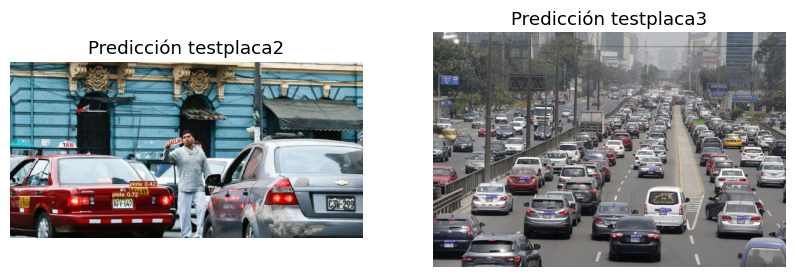

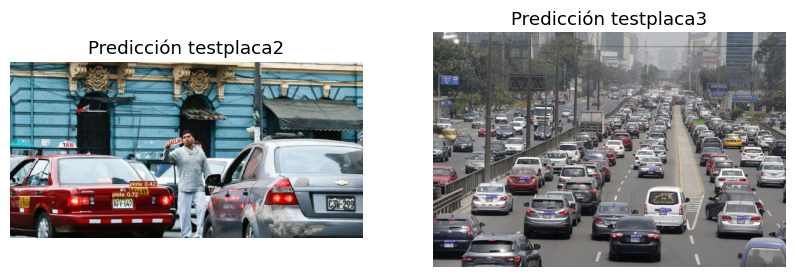

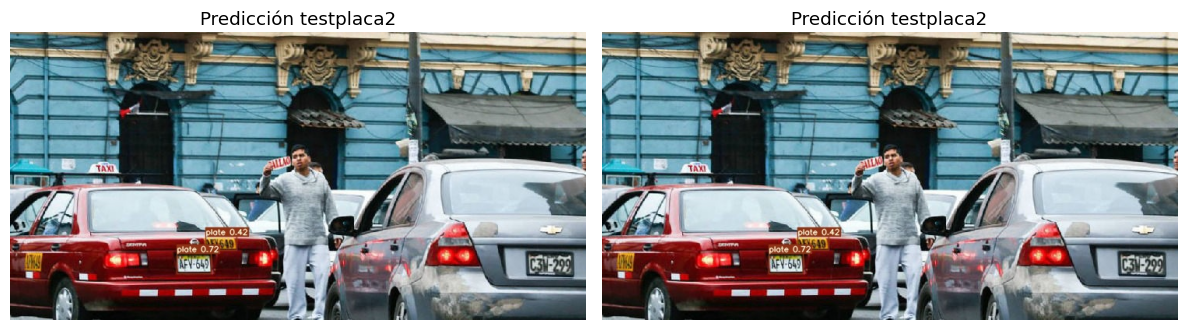

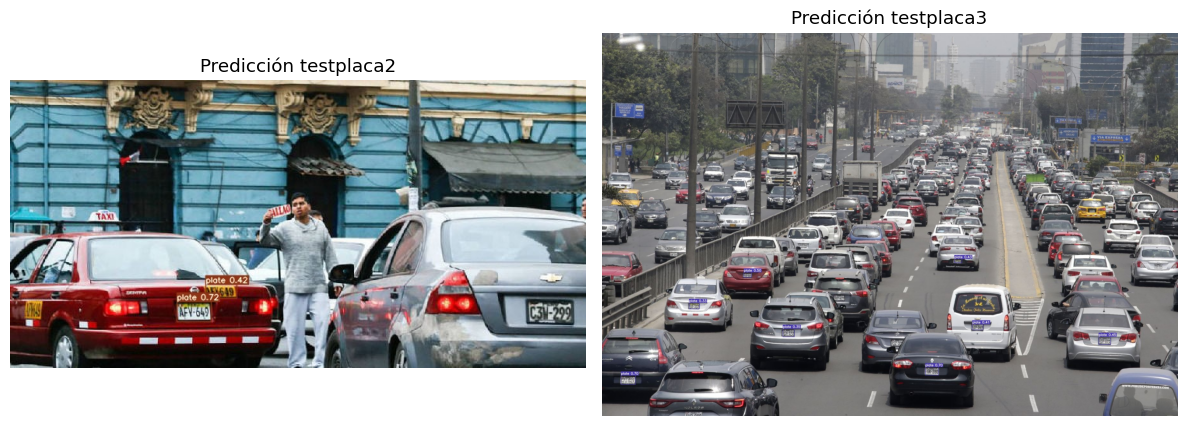

In [ ]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt

# Carga y muestra imágenes detectadas
img1_path = "yolov7/runs/detect/placa2/testplaca2.jpg"
img2_path = "yolov7/runs/detect/placa3/testplaca3.jpg"

img1 = Image.open(img1_path)
img2 = Image.open(img2_path)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title("Predicción testplaca2")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title("Predicción testplaca3")
plt.axis("off")

plt.tight_layout()
plt.show()


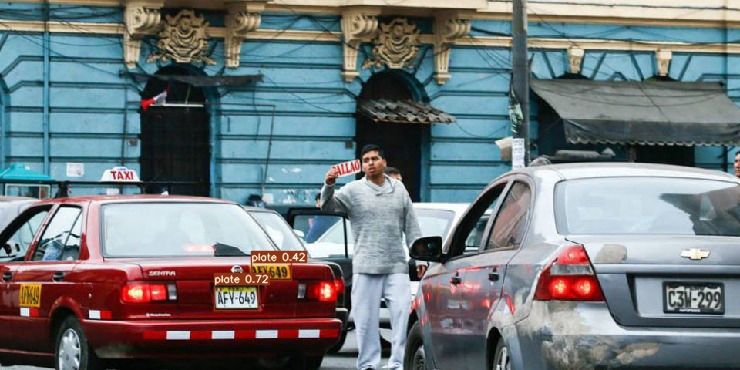

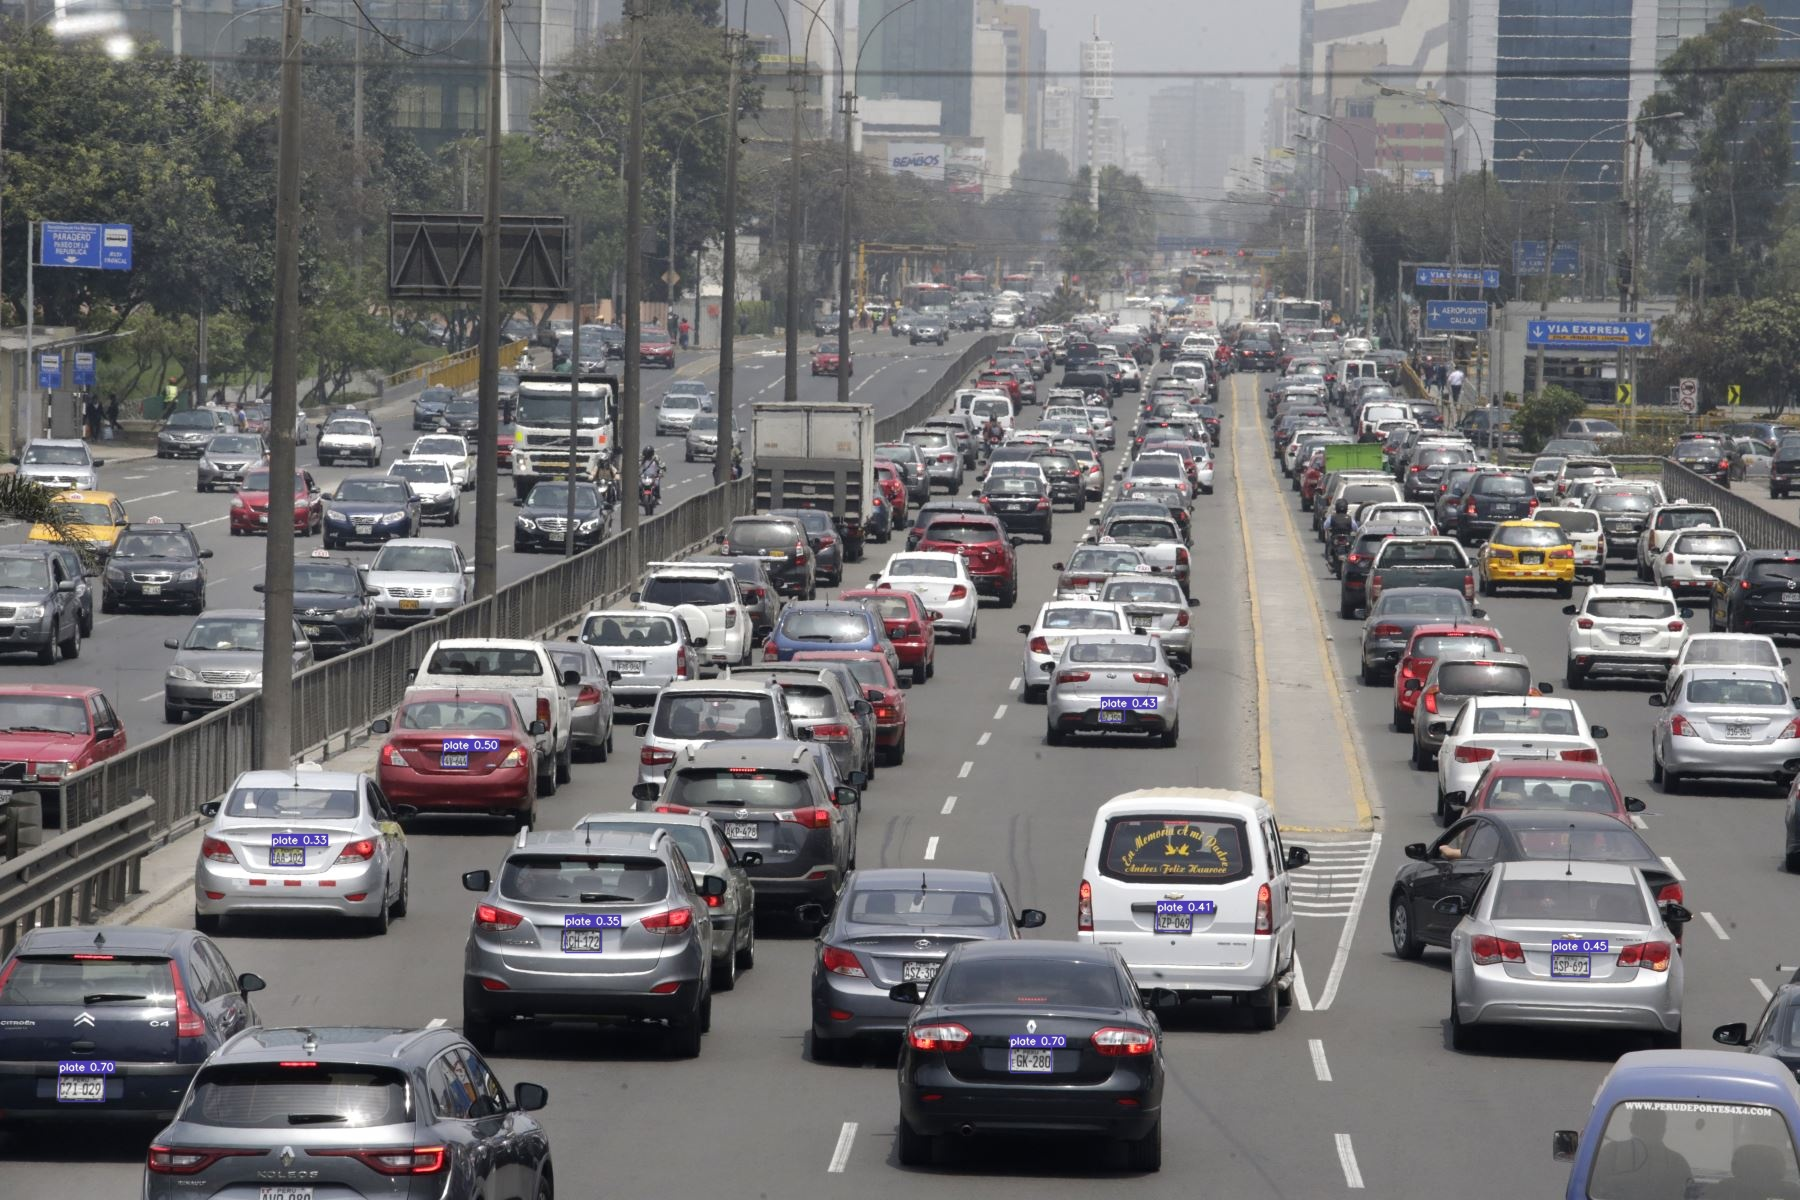

In [ ]:
from IPython.display import display
display(img1)
display(img2)
